## Predicting Images Categories with CNN: CIFAR-10 Dataset
### Problem:
- **Objective**: Predict category for CIFAR-10 dataset images into 10 different classes.
- **How**: Building a Convolutional Neural Network for Multi-Class Classification.
- **Dataset**: 60.000 color images 32x32 pixels of different categories (e.g., airplanes, cars, cats, dogs, etc.) (CIFAR-10 Dataset)
- **Target variable**: Category for the image

### Steps:
**Load the Dataset**: CIFAR-10 dataset from Torchvision ([Link Here](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html))

**Preprocess the Data**:
  1) Define transform for preprocessing the data (normalizing pixel values between 0 and 1)
  2) Load the train CIFAR-10 dataset
  3) Load the test CIFAR-10 dataset
  4) Create DataLoaders for train and test sets

**Build the Neural Network**: Convolutional Neural Network with the following layers:

*Convolutional Layers*: Each convolutional layer uses a 3x3 kernel to extract features. The number of filters (32 and 64) increases as we go deeper into the network.

*Max Pooling Layers*: Max-pooling layers reduce the size of the feature maps (2x2 window), keeping the most important information.

*Fully Connected Layers*: After flattening the 3D output from the convolutional layers, the fully connected layers are used to classify the image into one of the 10 classes.

**Train the Model**: 
 1) Use the Cross Entropy loss function and Adam optimizer. 
 2) Train for 10 epochs.
 3) Calculate and print the train loss during training.

**Evaluate the Model**:  
 1) Calculate test loss after training.
 2) Plot training loss curve
 3) Calculate R-squared
 4) Plot Confusion Matrix

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

100%|██████████████████████████████████████████████████████████████| 170498071/170498071 [00:14<00:00, 11775440.99it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

In [4]:
image, label = train_dataset[0]
print(f'Image shape: {image.shape}, Label: {label}')

Image shape: torch.Size([3, 32, 32]), Label: 6


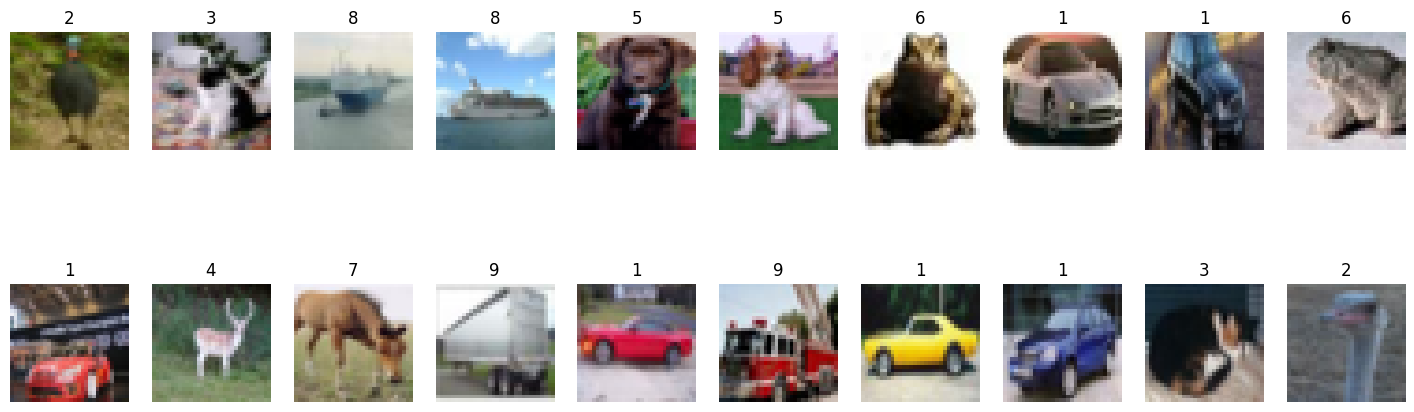

In [5]:
# Plot CIFAR-10 images
figure = plt.figure(figsize=(18, 6))
cols, rows = 10, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    # Denormalize the image for proper visualization
    img = img * 0.5 + 0.5  # Reverse the normalization (0.5 mean, 0.5 std)
    
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    
    # Convert from Tensor to NumPy and transpose the channels (C, H, W) -> (H, W, C)
    plt.imshow(img.permute(1, 2, 0))  # For RGB images, no need to use cmap="gray"
    
plt.show()

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # First conv layer (32 filters)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second conv layer (64 filters)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer (2x2 window)

        # Define fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # 64 feature maps of size 8x8
        self.fc2 = nn.Linear(512, 10)  # 10 classes

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))

        # Flatten the output from the conv layers
        x = x.view(-1, 64 * 8 * 8)

        # Apply fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [7]:
model = CNN()

In [8]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
epochs = 10
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()

        pred = model(images)
        loss_fn = loss(pred, labels)

        loss_fn.backward()
        optimizer.step()

        running_loss += loss_fn.item()
        #print(running_loss)
    # Print the average loss after each epoch
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 1/10, Loss: 1.2958
Epoch 2/10, Loss: 0.9015
Epoch 3/10, Loss: 0.7180
Epoch 4/10, Loss: 0.5583
Epoch 5/10, Loss: 0.4097
Epoch 6/10, Loss: 0.2767
Epoch 7/10, Loss: 0.1661
Epoch 8/10, Loss: 0.1095
Epoch 9/10, Loss: 0.0876
Epoch 10/10, Loss: 0.0749


In [10]:
correct = 0
total = 0

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')

Accuracy on the test set: 97.76%
